### Detect cloud bands between 29 March and 1 April 2002 using ERA5 3 hourly olr data, and create maps showing the evolution of the cloud bands. This study is based on Knipertz (2005)

Knippertz, P., 2005: Tropical–Extratropical Interactions Associated with an Atlantic Tropical Plume and Subtropical Jet Streak. Mon. Wea. Rev., 133, 2759–2776, https://doi.org/10.1175/MWR2999.1

In [1]:
import os
import string
from datetime import datetime
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config, get_variable_lonlat_from_domain
from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.figure_tools import set_fontsize

Load configuration file and make adjustements for this test case

In [2]:
config_file = "../config/config_cbworkflow_northernhemisphere.yml"
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20020329.00"
config_event["enddate"] = "20020401.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata = "../data/"
config_event["clouddata_path"] = os.path.join("../data")
config_event["parameters_file"] = os.path.join("../parameters/parameters_northhemisphere.yml")
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

2023-11-23 17:17:24,192 - io_utilities.load_ymlfile - INFO: Configuration file loaded


Load ERA5 data and get its resolution, and load parameters file. The ERA5 file contains OLR data from 01.01.2016 to 30.05.2016.

In [3]:
olr2process, parameters, listofdates, lats_in, lons_in, resolution = run_load_data(config_event)
config_event["lat_south"] = 0
lat_north = config_event["lat_north"]
lat_south = config_event["lat_south"]
lon_west = config_event["lon_west"]
lon_east = config_event["lon_east"]
olr, lons, lats = get_variable_lonlat_from_domain(
    olr2process, lons_in, lats_in, lon_west, lon_east, lat_north, lat_south
)
# add cyclic
cyc_olr, clons = cutil.add_cyclic_point(olr, lons)

2023-11-23 17:17:24,200 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-11-23 17:17:24,203 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-11-23 17:17:24,204 - io_utilities.load_dataset - INFO: Loading dataset from ../data
2023-11-23 17:17:24,205 - io_utilities.load_dataset - INFO: Loading 2002 --> 2002
2023-11-23 17:17:34,991 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-11-23 17:17:34,994 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-11-23 17:17:35,076 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-11-23 17:17:35,078 - io_utilities.load_dataset - INFO: Dataset loaded
2023-11-23 17:17:35,133 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done


Run cloud band detection for each day

In [4]:
(
    _,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_over_time,
    _,
    list_of_cloudbands,
) = detection_workflow(
    var2process=cyc_olr,
    parameters=parameters,
    latitudes=lats,
    longitudes=clons,
    resolution=resolution,
    listofdates=listofdates,
    config=config_event,
)

2023-11-23 17:17:35,143 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-11-23 17:17:35,144 - cb_detection.detection_workflow - INFO: Blobs that are longitudinally crossing the map will be connected
2023-11-23 17:17:35,386 - cb_detection.detection_workflow - INFO: Cloud band detection done


#### Figure of OLR and cloud bands (shading) and of labelled cloud band candidates (contour). Lines show where the cloud bands must cross to be defined as a cloud band.

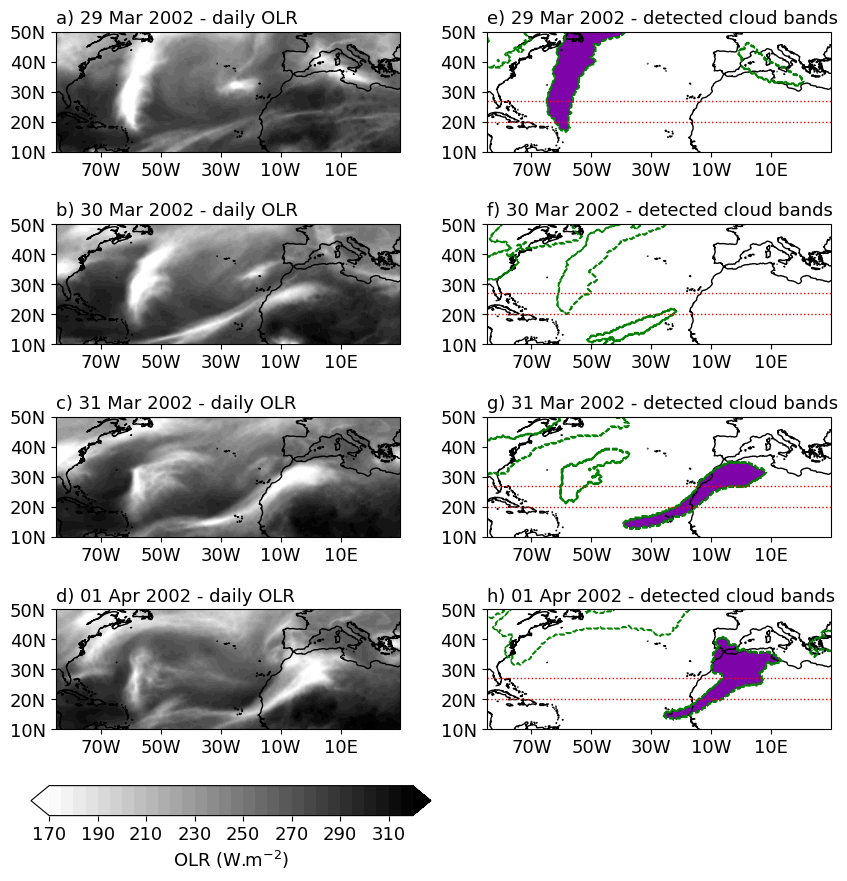

In [5]:
nrows = 4
ncols = 2
# for dates in title
date_format = "%d %b %Y"
dates = [el.strftime(date_format) for el in listofdates]  # Replace with your specific dates
# Generate the alphabet labels for the titles
alphabet_labels_left = [f"{letter})" for letter in string.ascii_lowercase[:nrows]]
iterator_labels_left = iter(alphabet_labels_left)
alphabet_labels_right = [f"{letter})" for letter in string.ascii_lowercase[nrows:nrows * ncols]]
iterator_labels_right = iter(alphabet_labels_right)


# Set graphic properties
set_fontsize(13)
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
# Create a color map for olr data
cmap_olr = plt.cm.get_cmap('binary')
# Create a color map for detected cloud bands
cmap_detected = plt.cm.get_cmap('plasma')
# Create a map projection
projection = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows, ncols, width_ratios=[1, 1])

for i in range(4):
    # Plot OLR data in the first column
    ax_olr = fig.add_subplot(gs[i, 0], projection=projection)
    # Panels titles
    title = f"{next(iterator_labels_left)} {dates[i]} - daily OLR"
    ax_olr.set_title(title, loc="left")
    cs_olr = ax_olr.contourf(clons, lats, cyc_olr[i], cmap=cmap_olr, levels=range(170, 325, 5), extend="both", transform=projection)
    ax_olr.coastlines()
    lonticks = np.arange(-90, 30, 20)
    latticks = np.arange(0, 60, 10)
    ax_olr.set_xticks(lonticks, crs=ccrs.PlateCarree())
    ax_olr.set_yticks(latticks, crs=ccrs.PlateCarree())
    ax_olr.xaxis.set_major_formatter(LON_FORMAT)
    ax_olr.yaxis.set_major_formatter(LAT_FORMAT)
    ax_olr.set_extent([-85, 30, 33, 0])
    ax_olr.set_ylim([10, 50])
    # Plot cloud bands in the second column
    ax_detected = fig.add_subplot(gs[i, 1], projection=projection)
    # Panels titles
    title = f"{next(iterator_labels_right)} {dates[i]} - detected cloud bands"
    ax_detected.set_title(title, loc="left")
    ax_detected.contourf(
            clons, lats, np.ma.masked_where(cloud_bands_over_time[i] == 0, cloud_bands_over_time[i]), cmap=cmap_detected, transform=projection
        )
    ax_detected.contour(clons, lats, labelled_candidates[i], colors="g", linestyles="--", linewidths=1, dash_sequence=[2, 10, 2, 10])
    gl2 = ax_detected.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl2.ylocator = mticker.FixedLocator([0, 27])
    gl2.xlines = False
    gl3 = ax_detected.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl3.ylocator = mticker.FixedLocator([0, 20])
    gl3.xlines = False
    ax_detected.coastlines()
    lonticks = np.arange(-90, 30, 20)
    latticks = np.arange(0, 60, 10)
    ax_detected.set_xticks(lonticks, crs=ccrs.PlateCarree())
    ax_detected.set_yticks(latticks, crs=ccrs.PlateCarree())
    ax_detected.xaxis.set_major_formatter(LON_FORMAT)
    ax_detected.yaxis.set_major_formatter(LAT_FORMAT)
    ax_detected.set_extent([-85, 30, 33, 0])
    ax_detected.set_ylim([10, 50])


cax = fig.add_axes([0.1, 0.06, 0.4, 0.03])
cbar = fig.colorbar(cs_olr, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r"OLR (W.m$^{-2}$)")

fig.subplots_adjust(wspace=0.25, hspace=0.0)
plt.savefig("knipertz2005_study.png", dpi=300, bbox_inches="tight")
plt.show()

### Test zone

Now, we change the OLR threshold to 240 W/m2 for the detection in order to get the same cloud band as in Knipertz (2005).

In [6]:
parameters["OLR_THRESHOLD"] = 240
(
    _,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_over_time,
    _,
    list_of_cloudbands,
) = detection_workflow(
    var2process=cyc_olr,
    parameters=parameters,
    latitudes=lats,
    longitudes=clons,
    resolution=resolution,
    listofdates=listofdates,
    config=config_event,
)

2023-11-23 17:18:10,573 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-11-23 17:18:10,575 - cb_detection.detection_workflow - INFO: Blobs that are longitudinally crossing the map will be connected
2023-11-23 17:18:10,880 - cb_detection.detection_workflow - INFO: Cloud band detection done


Figure of  the mean of all the labelled cloud band candidates overlayed by the contour of the mean of cloud band. Lines show where the cloud bands must cross to be defined as a cloud band.

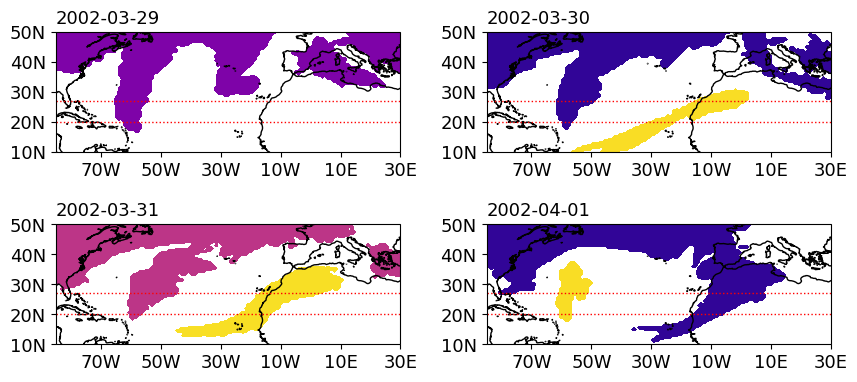

In [7]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)}, figsize=(10, 5)
)
for idx, axs in enumerate(axs.ravel()):
    fill = axs.contourf(
        clons, lats, np.ma.masked_where(cloud_bands_over_time[idx] == 0, cloud_bands_over_time[idx]), cmap="plasma"
    )
    lonticks = np.arange(-90, 40, 20)
    latticks = np.arange(0, 60, 10)
    axs.set_xticks(lonticks, crs=ccrs.PlateCarree())
    axs.set_yticks(latticks, crs=ccrs.PlateCarree())
    axs.xaxis.set_major_formatter(LON_FORMAT)
    axs.yaxis.set_major_formatter(LAT_FORMAT)
    axs.coastlines()
    axs.set_extent([-85, 30, 33, 0])
    axs.set_ylim([10, 50])
    axs.set_title(f"{listofdates[idx].strftime('%Y-%m-%d')}", loc="left")
    gl2 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl2.ylocator = mticker.FixedLocator([0, 27])
    gl2.xlines = False
    gl3 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl3.ylocator = mticker.FixedLocator([0, 20])
    gl3.xlines = False

fig.subplots_adjust(wspace=0.25, hspace=0.0)
fig.show()